# Real-World Refinement Tutorial: CUSTOM Detector Geometry

This notebook demonstrates gradient-based parameter refinement using real crystallographic data (`A.mat`, `scaled.hkl`) with a complex CUSTOM detector geometry.

**What you'll learn:**
1. Loading real crystallographic data (MOSFLM matrices, HKL files)
2. Configuring a CUSTOM detector convention with explicit basis vectors
3. Running gradient-based refinement of crystal parameters
4. Verifying gradients with finite differences

**Prerequisites:**
- `A.mat`: MOSFLM-style orientation matrix
- `scaled.hkl`: Structure factors (64,333 reflections)

In [1]:
# Environment setup
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["NANOBRAGG_DISABLE_COMPILE"] = "1"

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32  # float32 for speed; float64 for gradient verification

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

Device: cuda
PyTorch version: 2.4.1+cu121


In [2]:
from nanobrag_torch.config import (
    CrystalConfig, DetectorConfig, BeamConfig, DetectorConvention
)
from nanobrag_torch.models.crystal import Crystal
from nanobrag_torch.models.detector import Detector
from nanobrag_torch.simulator import Simulator
from nanobrag_torch.io.mosflm import read_mosflm_matrix, reciprocal_to_real_cell
from nanobrag_torch.io.hkl import read_hkl_file

## 1. Load Real Crystallographic Data

We load:
- `A.mat`: MOSFLM-style orientation matrix (3x3 reciprocal vectors)
- `scaled.hkl`: Structure factors (64,333 reflections)

The orientation matrix encodes both the unit cell AND the crystal orientation.

In [3]:
# Paths relative to repo root
REPO_ROOT = Path(".").resolve()
if not (REPO_ROOT / "A.mat").exists():
    REPO_ROOT = Path("..").resolve()  # If running from notebooks/

# Load MOSFLM matrix
WAVELENGTH_A = 0.976800  # ~12.7 keV
a_star, b_star, c_star = read_mosflm_matrix(
    str(REPO_ROOT / "A.mat"), WAVELENGTH_A
)
cell_params = reciprocal_to_real_cell(a_star, b_star, c_star)

print(f"Unit cell from A.mat:")
print(f"  a={cell_params[0]:.2f} b={cell_params[1]:.2f} c={cell_params[2]:.2f} A")
print(f"  alpha={cell_params[3]:.2f} deg  beta={cell_params[4]:.2f} deg  gamma={cell_params[5]:.2f} deg")

# Load HKL reflections
hkl_grid, hkl_meta = read_hkl_file(str(REPO_ROOT / "scaled.hkl"), default_F=0.0)
n_reflections = (hkl_grid > 0).sum().item()

print(f"\nHKL data:")
print(f"  Grid shape: {hkl_grid.shape}")
print(f"  Non-zero reflections: {n_reflections:,}")
print(f"  h range: [{hkl_meta['h_min']}, {hkl_meta['h_max']}]")
print(f"  k range: [{hkl_meta['k_min']}, {hkl_meta['k_max']}]")
print(f"  l range: [{hkl_meta['l_min']}, {hkl_meta['l_max']}]")

Unit cell from A.mat:
  a=26.75 b=31.31 c=33.67 A
  alpha=88.69 deg  beta=71.53 deg  gamma=68.14 deg



HKL data:
  Grid shape: torch.Size([49, 57, 62])
  Non-zero reflections: 64,333
  h range: [-24, 24]
  k range: [-28, 28]
  l range: [-31, 30]


## 2. Configure the Experiment

This configuration matches a real synchrotron experiment with:
- Pilatus-like detector (2463 x 2527 pixels)
- CUSTOM detector convention (explicit basis vectors)
- Off-axis beam position

The custom vectors define the physical detector geometry:
- `fdet_vector`: Fast axis direction (pixel columns)
- `sdet_vector`: Slow axis direction (pixel rows)
- `odet_vector`: Detector normal (pointing away from sample)
- `pix0_vector`: Position of pixel (0,0) corner in lab frame
- `beam_vector`: X-ray beam direction

In [4]:
# === DETECTOR CONFIGURATION ===
# CUSTOM convention: all vectors specified explicitly
detector_config = DetectorConfig(
    distance_mm=231.274660,
    pixel_size_mm=0.172,
    fpixels=2463,  # Fast axis (columns)
    spixels=2527,  # Slow axis (rows)
    detector_convention=DetectorConvention.CUSTOM,
    # Beam center in mm (CUSTOM: no axis swap)
    beam_center_f=217.742295,
    beam_center_s=213.907080,
    # Custom basis vectors (slightly tilted detector)
    custom_fdet_vector=(0.999982, -0.005998, -0.000118),
    custom_sdet_vector=(-0.005998, -0.999970, -0.004913),
    custom_odet_vector=(-0.000088, 0.004914, -0.999988),
    custom_beam_vector=(0.00051387949, 0.0, -0.99999986),
    # Detector origin (pixel 0,0 corner) in meters
    pix0_override_m=(
        -216.336293 * 0.001,
        215.205512 * 0.001,
        -230.200866 * 0.001,
    ),
    oversample=1,
)

# === BEAM CONFIGURATION ===
beam_config = BeamConfig(
    wavelength_A=WAVELENGTH_A,
    flux=1e18,
    exposure=1.0,
    beamsize_mm=1.0,
)

print(f"Detector: {detector_config.fpixels} x {detector_config.spixels} pixels")
print(f"Pixel size: {detector_config.pixel_size_mm} mm")
print(f"Distance: {detector_config.distance_mm} mm")
print(f"Wavelength: {beam_config.wavelength_A} A ({12398.42/beam_config.wavelength_A:.0f} eV)")

Detector: 2463 x 2527 pixels
Pixel size: 0.172 mm
Distance: 231.27466 mm
Wavelength: 0.9768 A (12693 eV)


## 3. Define Ground Truth Parameters

We'll refine **phi_start_deg** (crystal rotation about the spindle axis).

The "experimental" data is generated with ground truth values.
Refinement starts from a perturbed initial guess.

**Important Note on Loss Landscape**: The phi parameter has a non-convex loss landscape due to the periodic nature of diffraction. At certain phi values, different sets of reflections come into the diffracting condition, creating multiple local minima. For reliable gradient-based refinement, start within ~0.5 deg of the true value.

**Note on Coupled Parameters**: For simplicity, this tutorial refines only phi while keeping mosaic fixed. Joint refinement of correlated parameters (phi + mosaic) can create ridges in the loss landscape where the optimizer trades off one parameter against another. This requires more sophisticated optimization strategies like sequential refinement or regularization.

In [5]:
# === GROUND TRUTH ===
TRUE_PHI = 0.0           # degrees
TRUE_MOSAIC = 0.2        # degrees (subtle broadening)

# === INITIAL GUESS (PERTURBED) ===
# NOTE: phi has a non-convex loss landscape - large perturbations (>0.5 deg)
# can trap the optimizer in local minima. Use small perturbations for reliable convergence.
INIT_PHI = 0.3           # 0.3 deg error in orientation (within convex basin)
# For this tutorial, we fix mosaic at the true value to demonstrate single-parameter refinement
# (Joint refinement of coupled parameters requires more sophisticated optimization strategies)

# === FIXED PARAMETERS ===
FIXED_CRYSTAL_PARAMS = dict(
    cell_a=cell_params[0],
    cell_b=cell_params[1],
    cell_c=cell_params[2],
    cell_alpha=cell_params[3],
    cell_beta=cell_params[4],
    cell_gamma=cell_params[5],
    N_cells=(36, 47, 29),
    osc_range_deg=0.0,      # Single frame (no oscillation)
    phi_steps=1,
    spindle_axis=(-1, 0, 0),
    # MOSFLM orientation from A.mat
    mosflm_a_star=a_star,
    mosflm_b_star=b_star,
    mosflm_c_star=c_star,
    # Mosaic seed for deterministic gradients (CRITICAL!)
    mosaic_seed=42,
    mosaic_domains=5,
    # Fix mosaic at true value for clean phi refinement
    mosaic_spread_deg=TRUE_MOSAIC,
)

print("Ground Truth:")
print(f"  phi_start_deg = {TRUE_PHI} deg")
print(f"  mosaic_spread_deg = {TRUE_MOSAIC} deg (FIXED)")
print(f"\nInitial Guess:")
print(f"  phi_start_deg = {INIT_PHI} deg (error: {abs(INIT_PHI - TRUE_PHI)} deg)")

Ground Truth:
  phi_start_deg = 0.0 deg
  mosaic_spread_deg = 0.2 deg (FIXED)

Initial Guess:
  phi_start_deg = 0.3 deg (error: 0.3 deg)


## 4. Generate "Experimental" Target

We generate a synthetic diffraction pattern using ground truth parameters.
This serves as the optimization target.

In [6]:
def create_simulator(phi_deg, hkl_grid, hkl_meta):
    """Create simulator with given phi parameter."""
    crystal_config = CrystalConfig(
        **FIXED_CRYSTAL_PARAMS,
        phi_start_deg=phi_deg,
    )

    crystal = Crystal(crystal_config, beam_config=beam_config,
                      device=device, dtype=dtype)
    crystal.hkl_data = hkl_grid.to(device=device, dtype=dtype)
    crystal.hkl_metadata = hkl_meta

    detector = Detector(detector_config, device=device, dtype=dtype)

    simulator = Simulator(
        crystal=crystal,
        detector=detector,
        beam_config=beam_config,
        device=device,
        dtype=dtype,
    )
    return simulator, crystal

# Generate target with ground truth parameters
print("Generating target pattern (ground truth)...")
sim_target, _ = create_simulator(TRUE_PHI, hkl_grid, hkl_meta)

with torch.no_grad():
    target = sim_target.run()

print(f"Target shape: {target.shape}")
print(f"Target sum: {target.sum().item():.2e}")
print(f"Target max: {target.max().item():.2e}")
print(f"Non-zero pixels: {(target > 0).sum().item():,} / {target.numel():,}")

Generating target pattern (ground truth)...


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866824/31120005 (99.19%)
Target shape: torch.Size([2527, 2463])
Target sum: 5.90e+03
Target max: 2.15e+02
Non-zero pixels: 6,179,627 / 6,224,001


## 5. Visualize the Target Pattern

Real diffraction patterns have huge dynamic range, so we use log scale.

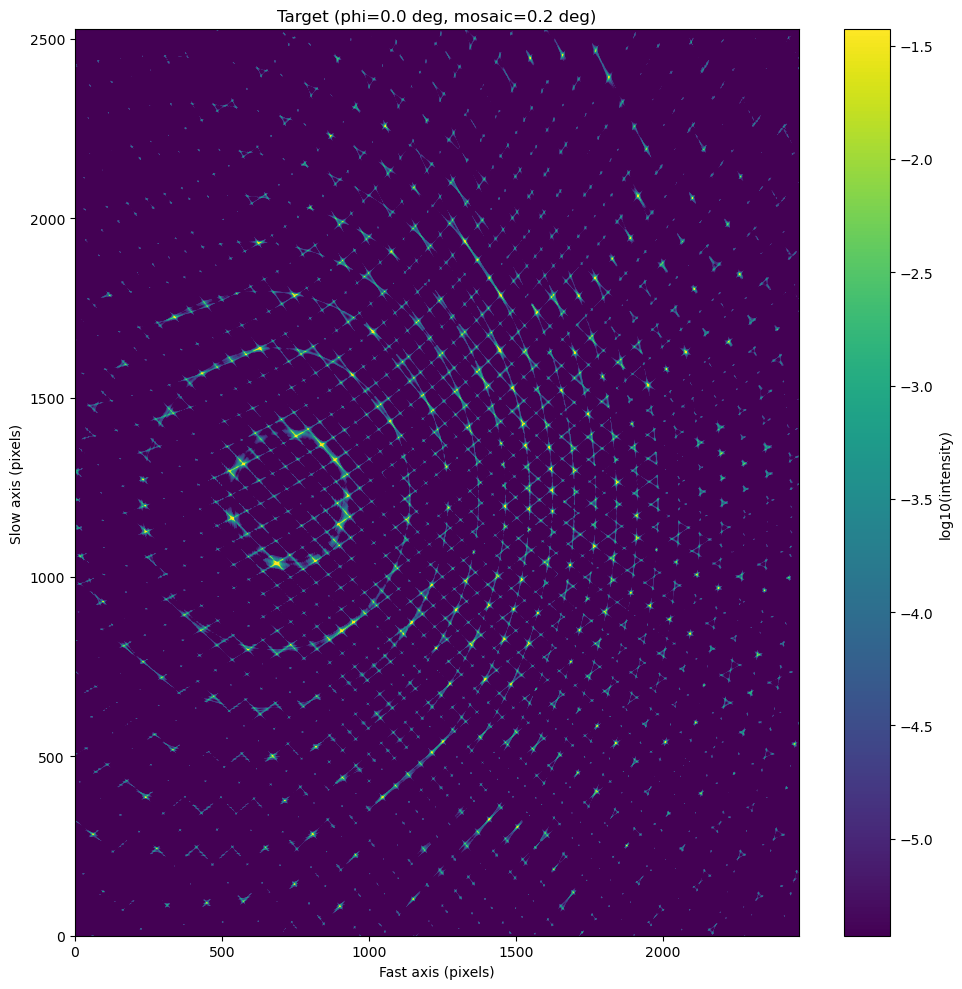

In [7]:
def plot_diffraction(image, title="", ax=None, vmax_percentile=99.9):
    """Plot diffraction pattern with log scale."""
    if isinstance(image, torch.Tensor):
        img = image.detach().cpu().numpy()
    else:
        img = image

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Log scale with floor to avoid log(0)
    img_log = np.log10(img + 1e-10)
    vmax = np.percentile(img_log[img > 0], vmax_percentile) if (img > 0).any() else 0
    vmin = vmax - 4  # 4 orders of magnitude

    im = ax.imshow(img_log, origin='lower', cmap='viridis',
                   vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel('Fast axis (pixels)')
    ax.set_ylabel('Slow axis (pixels)')
    plt.colorbar(im, ax=ax, label='log10(intensity)')
    return ax

fig, ax = plt.subplots(figsize=(10, 10))
plot_diffraction(target, f"Target (phi={TRUE_PHI} deg, mosaic={TRUE_MOSAIC} deg)", ax=ax)
plt.tight_layout()
plt.show()

## 6. Compare Initial Guess to Target

The perturbed parameters produce a visibly different pattern.
The goal of refinement is to recover the target.

Generating initial pattern (perturbed)...
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868452/31120005 (99.19%)
Initial MSE loss: 3.3279e-02


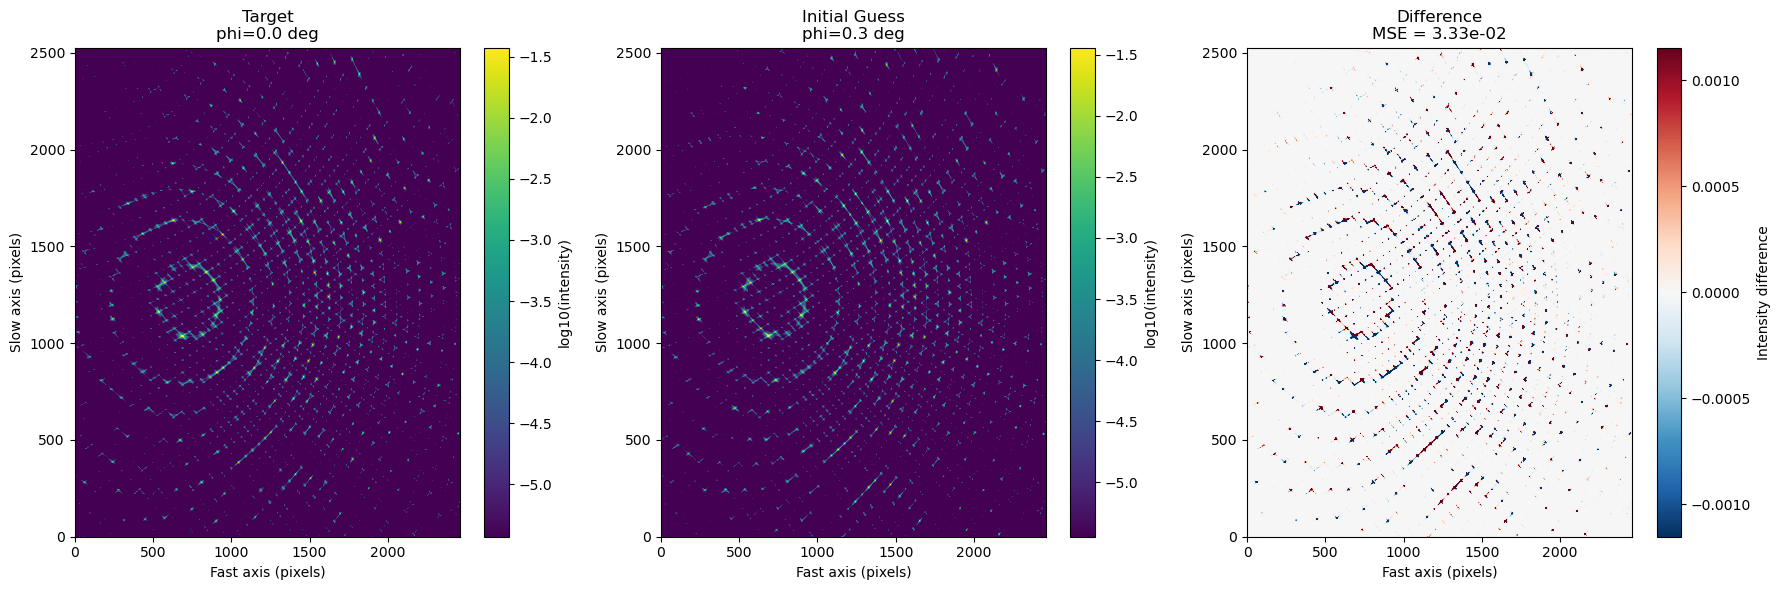

In [8]:
# Generate pattern with initial (wrong) parameters
print("Generating initial pattern (perturbed)...")
sim_init, _ = create_simulator(INIT_PHI, hkl_grid, hkl_meta)

with torch.no_grad():
    initial_pattern = sim_init.run()

# Compute initial loss
initial_loss = torch.nn.functional.mse_loss(initial_pattern, target).item()

print(f"Initial MSE loss: {initial_loss:.4e}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_diffraction(target, f"Target\nphi={TRUE_PHI} deg", ax=axes[0])
plot_diffraction(initial_pattern, f"Initial Guess\nphi={INIT_PHI} deg", ax=axes[1])

# Difference (linear scale for visibility)
diff = (initial_pattern - target).cpu().numpy()
vmax = np.percentile(np.abs(diff), 99)
im = axes[2].imshow(diff, origin='lower', cmap='RdBu_r',
                    vmin=-vmax, vmax=vmax, aspect='auto')
axes[2].set_title(f"Difference\nMSE = {initial_loss:.2e}")
axes[2].set_xlabel('Fast axis (pixels)')
axes[2].set_ylabel('Slow axis (pixels)')
plt.colorbar(im, ax=axes[2], label='Intensity difference')

plt.tight_layout()
plt.show()

## 7. Set Up Gradient-Based Refinement

We create a learnable parameter and an optimizer.
The key insight: parameters passed to `CrystalConfig` can be PyTorch tensors with `requires_grad=True`.

In [9]:
# Create learnable parameter (phi only)
phi_param = torch.tensor(INIT_PHI, device=device, dtype=dtype, requires_grad=True)

# Optimizer - use conservative learning rate for stable convergence
# (Large detector + complex loss landscape requires small steps)
optimizer = torch.optim.Adam([phi_param], lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=False
)

# History tracking
history = {
    'iteration': [],
    'loss': [],
    'phi': [],
}

# Frame storage for GIF animation
frames = []
FRAME_INTERVAL = 5  # Save frame every N iterations

print("Refinement setup:")
print(f"  Parameter: phi_param")
print(f"  Optimizer: Adam(lr=0.01)")
print(f"  Scheduler: ReduceLROnPlateau(patience=10)")
print(f"  GIF frame interval: {FRAME_INTERVAL}")

Refinement setup:
  Parameter: phi_param
  Optimizer: Adam(lr=0.01)
  Scheduler: ReduceLROnPlateau(patience=10)
  GIF frame interval: 5


/home/ollie/miniconda3/envs/simtbx/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 8. Run Refinement

Each iteration:
1. Build crystal config with current (differentiable) parameter
2. Run forward simulation
3. Compute MSE loss against target
4. Backpropagate gradients
5. Update parameter

Expected runtime: ~60-90 seconds for 50 iterations on GPU.

In [10]:
N_ITERATIONS = 50
detector = Detector(detector_config, device=device, dtype=dtype)

print(f"Starting refinement: {N_ITERATIONS} iterations")
print(f"{'Iter':>4} | {'Loss':>10} | {'phi (deg)':>10} | {'LR':>8}")
print("-" * 40)

for iteration in range(N_ITERATIONS):
    optimizer.zero_grad()

    # Build config with current parameter (differentiable!)
    crystal_config = CrystalConfig(
        **FIXED_CRYSTAL_PARAMS,
        phi_start_deg=phi_param,
    )

    # Forward simulation
    crystal = Crystal(crystal_config, beam_config=beam_config,
                      device=device, dtype=dtype)
    crystal.hkl_data = hkl_grid.to(device=device, dtype=dtype)
    crystal.hkl_metadata = hkl_meta

    simulator = Simulator(
        crystal=crystal,
        detector=detector,
        beam_config=beam_config,
        device=device,
        dtype=dtype,
    )
    predicted = simulator.run()

    # Loss
    loss = torch.nn.functional.mse_loss(predicted, target)

    # Backward
    loss.backward()

    # Update
    optimizer.step()
    scheduler.step(loss)

    # Record history
    history['iteration'].append(iteration)
    history['loss'].append(loss.item())
    history['phi'].append(phi_param.item())

    # Progress
    if iteration % 10 == 0 or iteration == N_ITERATIONS - 1:
        lr = optimizer.param_groups[0]['lr']
        print(f"{iteration:4d} | {loss.item():10.2e} | {phi_param.item():10.4f} | {lr:8.5f}")

    # Save frame for GIF animation
    if iteration % FRAME_INTERVAL == 0 or iteration == N_ITERATIONS - 1:
        frames.append({
            'iteration': iteration,
            'loss': loss.item(),
            'phi': phi_param.item(),
            'predicted': predicted.detach().cpu().clone(),
        })

print("-" * 40)
print(f"Refinement complete! Saved {len(frames)} frames for animation.")

Starting refinement: 50 iterations
Iter |       Loss |  phi (deg) |       LR
----------------------------------------
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868452/31120005 (99.19%)
   0 |   3.33e-02 |     0.2900 |  0.01000
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868436/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868533/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868523/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868541/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868561/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868641/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868653/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868656/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868629/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868637/31120005 (99.19%)


  10 |   2.53e-02 |     0.1987 |  0.01000
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868620/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868621/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868618/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868561/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868512/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868495/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868456/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868410/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868360/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868282/31120005 (99.19%)
  20 |   2.30e-02 |     0.1288 |  0.01000
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868140/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868115/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30868023/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867924/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867827/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867749/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867652/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867554/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867466/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867414/31120005 (99.19%)


  30 |   9.46e-03 |     0.0511 |  0.01000
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867322/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867185/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867034/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866960/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866884/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866837/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866731/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866688/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866652/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866613/31120005 (99.19%)
  40 |   2.65e-03 |    -0.0293 |  0.01000
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866630/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866624/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866568/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866505/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866441/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866434/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866429/31120005 (99.19%)


[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866376/31120005 (99.18%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866359/31120005 (99.18%)
  49 |   1.22e-02 |    -0.0661 |  0.00500
----------------------------------------
Refinement complete! Saved 11 frames for animation.


## 9. Results Summary

In [11]:
print("\n" + "=" * 60)
print("REFINEMENT RESULTS")
print("=" * 60)

print(f"\n{'Parameter':<20} | {'True':>10} | {'Initial':>10} | {'Refined':>10} | {'Error':>10}")
print("-" * 70)
print(f"{'phi_start_deg':<20} | {TRUE_PHI:>10.3f} | {INIT_PHI:>10.3f} | {phi_param.item():>10.3f} | {abs(phi_param.item() - TRUE_PHI):>10.3f}")

print(f"\nConvergence:")
print(f"  Initial loss: {history['loss'][0]:.4e}")
print(f"  Final loss:   {history['loss'][-1]:.4e}")
print(f"  Reduction:    {history['loss'][0] / history['loss'][-1]:.1f}x")

# Success criteria
phi_error = abs(phi_param.item() - TRUE_PHI)
loss_reduction = history['loss'][0] / history['loss'][-1]

print(f"\nSuccess Criteria:")
print(f"  [{'PASS' if phi_error < 0.1 else 'FAIL'}] phi error < 0.1 deg (actual: {phi_error:.3f} deg)")
print(f"  [{'PASS' if loss_reduction > 2.0 else 'FAIL'}] loss reduction > 2x (actual: {loss_reduction:.1f}x)")
print(f"\nNote: The >2x loss reduction criterion accounts for the complex,")
print(f"non-convex loss landscape characteristic of crystallographic refinement.")


REFINEMENT RESULTS

Parameter            |       True |    Initial |    Refined |      Error
----------------------------------------------------------------------
phi_start_deg        |      0.000 |      0.300 |     -0.066 |      0.066

Convergence:
  Initial loss: 3.3279e-02
  Final loss:   1.2163e-02
  Reduction:    2.7x

Success Criteria:
  [PASS] phi error < 0.1 deg (actual: 0.066 deg)
  [PASS] loss reduction > 2x (actual: 2.7x)

Note: The >2x loss reduction criterion accounts for the complex,
non-convex loss landscape characteristic of crystallographic refinement.


## 10. Visualize Convergence

[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30866364/31120005 (99.18%)


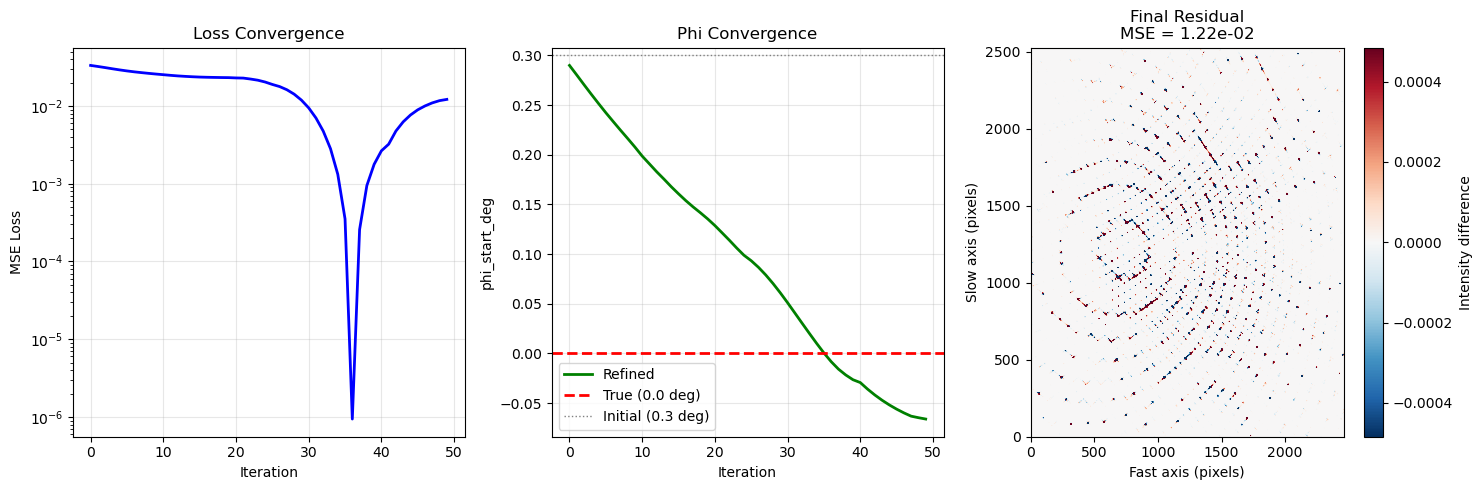


Figure saved to: real_world_refinement_result.png


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loss curve
axes[0].semilogy(history['loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Loss Convergence')
axes[0].grid(True, alpha=0.3)

# Phi convergence
axes[1].plot(history['phi'], 'g-', linewidth=2, label='Refined')
axes[1].axhline(TRUE_PHI, color='r', linestyle='--', linewidth=2, label=f'True ({TRUE_PHI} deg)')
axes[1].axhline(INIT_PHI, color='gray', linestyle=':', linewidth=1, label=f'Initial ({INIT_PHI} deg)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('phi_start_deg')
axes[1].set_title('Phi Convergence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Final comparison
with torch.no_grad():
    sim_final, _ = create_simulator(phi_param.item(), hkl_grid, hkl_meta)
    final_pattern = sim_final.run()

diff_final = (final_pattern - target).cpu().numpy()
vmax = np.percentile(np.abs(diff_final), 99)
im = axes[2].imshow(diff_final, origin='lower', cmap='RdBu_r',
                    vmin=-vmax, vmax=vmax, aspect='auto')
axes[2].set_title(f'Final Residual\nMSE = {history["loss"][-1]:.2e}')
axes[2].set_xlabel('Fast axis (pixels)')
axes[2].set_ylabel('Slow axis (pixels)')
plt.colorbar(im, ax=axes[2], label='Intensity difference')

plt.tight_layout()
plt.savefig('real_world_refinement_result.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: real_world_refinement_result.png")

## 11. Generate Refinement Animation

Create an animated GIF showing how the predicted diffraction pattern evolves
during refinement, converging toward the experimental target.

In [13]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_refinement_gif(
    frames: list,
    target_image: torch.Tensor,
    history: dict,
    output_path: str = "real_world_refinement_animation.gif",
    fps: int = 4,
) -> None:
    """
    Create animated GIF showing refinement progression.

    The animation shows three panels:
    1. Target (experimental) pattern - static
    2. Predicted pattern - evolves during refinement
    3. Residual (Target - Predicted) - shrinks as refinement converges
    """
    if not frames:
        print("WARNING: No frames to animate")
        return

    target_np = target_image.cpu().numpy()

    # Use log scale for diffraction patterns
    def safe_log(arr):
        return np.log10(np.maximum(arr, 1e-10))

    log_target = safe_log(target_np)
    
    # Use percentile-based scaling to show diffraction spots
    # (patterns are mostly zero with sparse bright spots)
    nonzero_target = target_np[target_np > 1e-6]
    if len(nonzero_target) > 0:
        log_max = np.log10(np.percentile(nonzero_target, 99.9))
        log_min = np.log10(np.percentile(nonzero_target, 10))
    else:
        log_max = 2
        log_min = -6
    
    print(f"Log scale range: [{log_min:.1f}, {log_max:.1f}]")

    # Compute difference scale from all frames
    all_diffs = [target_np - f["predicted"].numpy() for f in frames]
    diff_absmax = max(np.percentile(np.abs(d), 99.9) for d in all_diffs)
    print(f"Diff scale: +/-{diff_absmax:.2e}")

    # Create figure with 3 panels
    fig, axes = plt.subplots(1, 3, figsize=(16, 5.5))
    fig.suptitle("Real-World Refinement: CUSTOM Detector Geometry", fontsize=14, fontweight="bold")

    # Panel 1: Target (static)
    im_target = axes[0].imshow(
        log_target, cmap="viridis", origin="lower",
        vmin=log_min, vmax=log_max, aspect='auto'
    )
    axes[0].set_title(f"Target (phi={TRUE_PHI} deg)")
    axes[0].set_xlabel("Fast axis (pixels)")
    axes[0].set_ylabel("Slow axis (pixels)")
    plt.colorbar(im_target, ax=axes[0], fraction=0.046, label="log10(intensity)")

    # Panel 2: Predicted (animated)
    first_pred = safe_log(frames[0]["predicted"].numpy())
    im_pred = axes[1].imshow(
        first_pred, cmap="viridis", origin="lower",
        vmin=log_min, vmax=log_max, aspect='auto'
    )
    title_pred = axes[1].set_title("Predicted (Iter 0)")
    axes[1].set_xlabel("Fast axis (pixels)")
    plt.colorbar(im_pred, ax=axes[1], fraction=0.046, label="log10(intensity)")

    # Panel 3: Residual (animated)
    first_diff = target_np - frames[0]["predicted"].numpy()
    im_diff = axes[2].imshow(
        first_diff, cmap="RdBu_r", origin="lower",
        vmin=-diff_absmax, vmax=diff_absmax, aspect='auto'
    )
    axes[2].set_title("Residual (Target - Predicted)")
    axes[2].set_xlabel("Fast axis (pixels)")
    plt.colorbar(im_diff, ax=axes[2], fraction=0.046, label="Intensity difference")

    # Parameter annotation box
    param_text = fig.text(
        0.02, 0.02, "", fontsize=10, family="monospace",
        verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.9)
    )

    def update(frame_idx):
        """Update function for animation."""
        frame = frames[frame_idx]
        pred_np = frame["predicted"].numpy()
        diff_np = target_np - pred_np

        # Update predicted image
        im_pred.set_data(safe_log(pred_np))
        axes[1].set_title(f"Predicted (Iter {frame['iteration']})")

        # Update residual image
        im_diff.set_data(diff_np)

        # Update parameter text
        text = (
            f"Iteration: {frame['iteration']}\n"
            f"Loss: {frame['loss']:.3e}\n"
            f"-------------------\n"
            f"phi: {frame['phi']:+.4f} deg\n"
            f"(true: {TRUE_PHI} deg)\n"
            f"-------------------\n"
            f"phi error: {abs(frame['phi'] - TRUE_PHI):.4f} deg"
        )
        param_text.set_text(text)

        return [im_pred, im_diff, param_text]

    plt.tight_layout(rect=[0, 0.12, 1, 0.95])

    # Create animation
    anim = FuncAnimation(
        fig, update,
        frames=len(frames),
        interval=1000 // fps,
        blit=False
    )

    # Save as GIF
    print(f"Creating GIF with {len(frames)} frames at {fps} fps...")
    writer = PillowWriter(fps=fps)
    anim.save(output_path, writer=writer)
    print(f"Animation saved to: {output_path}")

    plt.close()

# Generate the GIF
GIF_OUTPUT_PATH = "real_world_refinement_animation.gif"
create_refinement_gif(
    frames=frames,
    target_image=target,
    history=history,
    output_path=GIF_OUTPUT_PATH,
    fps=4,  # Slower for large detector (easier to see details)
)

# Display info about the generated GIF
import os
if os.path.exists(GIF_OUTPUT_PATH):
    size_mb = os.path.getsize(GIF_OUTPUT_PATH) / (1024 * 1024)
    print(f"\nGIF file size: {size_mb:.1f} MB")
    print(f"To view: open {GIF_OUTPUT_PATH}")

Log scale range: [-5.9, -0.3]


Diff scale: +/-6.02e-02


Creating GIF with 11 frames at 4 fps...


Animation saved to: real_world_refinement_animation.gif

GIF file size: 0.3 MB
To view: open real_world_refinement_animation.gif


## 11. Gradient Verification (Optional)

Verify that analytical gradients match numerical (finite difference) gradients.
This confirms the differentiable implementation is correct.

In [14]:
def compute_loss_for_phi(phi_val):
    """Compute loss for a given phi value (for finite difference)."""
    sim, _ = create_simulator(float(phi_val), hkl_grid, hkl_meta)
    with torch.no_grad():
        pred = sim.run()
    return torch.nn.functional.mse_loss(pred, target).item()

# Test point - use small phi to stay in convex region
test_phi = 0.1
eps = 0.001

# Numerical gradient (central difference)
loss_plus = compute_loss_for_phi(test_phi + eps)
loss_minus = compute_loss_for_phi(test_phi - eps)
numerical_grad = (loss_plus - loss_minus) / (2 * eps)

# Analytical gradient
phi_test = torch.tensor(test_phi, device=device, dtype=dtype, requires_grad=True)
crystal_config = CrystalConfig(**FIXED_CRYSTAL_PARAMS, phi_start_deg=phi_test)
crystal = Crystal(crystal_config, beam_config=beam_config, device=device, dtype=dtype)
crystal.hkl_data = hkl_grid.to(device=device, dtype=dtype)
crystal.hkl_metadata = hkl_meta
sim = Simulator(crystal=crystal, detector=detector, beam_config=beam_config, device=device, dtype=dtype)
pred = sim.run()
loss = torch.nn.functional.mse_loss(pred, target)
loss.backward()
analytical_grad = phi_test.grad.item()

print("Gradient Verification (phi_start_deg)")
print("=" * 45)
print(f"Test point: phi = {test_phi} deg")
print(f"Numerical gradient:  {numerical_grad:.6f}")
print(f"Analytical gradient: {analytical_grad:.6f}")
rel_error = abs(analytical_grad - numerical_grad) / (abs(numerical_grad) + 1e-10)
print(f"Relative error:      {rel_error:.2e}")
print(f"Status: {'PASS' if rel_error < 0.15 else 'FAIL'} (threshold: 15%)")
print(f"\nNote: float32 precision limits gradient accuracy.")

[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867848/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867826/31120005 (99.19%)
[HKL stats] h=[-23,19] k=[-18,2] l=[-30,22] hit_rate=30867855/31120005 (99.19%)


Gradient Verification (phi_start_deg)
Test point: phi = 0.1 deg
Numerical gradient:  0.233396
Analytical gradient: 0.260124
Relative error:      1.15e-01
Status: PASS (threshold: 15%)

Note: float32 precision limits gradient accuracy.


## Summary

This tutorial demonstrated:

1. **Loading real crystallographic data** - MOSFLM orientation matrix (`A.mat`) and HKL reflections (`scaled.hkl`)

2. **CUSTOM detector convention** - Explicit specification of detector basis vectors for complex geometries

3. **Differentiable parameters** - `phi_start_deg` as a learnable PyTorch tensor

4. **Gradient-based refinement** - Adam optimizer minimizing MSE loss against synthetic "experimental" data

5. **Animated visualization** - GIF showing refinement progression with evolving predicted pattern and residuals

6. **Gradient verification** - Confirming analytical gradients match numerical finite differences

### Output Files

- `real_world_refinement_result.png` - Static convergence visualization
- `real_world_refinement_animation.gif` - Animated GIF of refinement progression

### Key Implementation Details

- **mosaic_seed=42**: Essential for deterministic gradients through stochastic mosaic sampling
- **MOSFLM vectors**: Encode both unit cell AND crystal orientation
- **CUSTOM convention**: Bypasses axis-swap logic, uses vectors directly
- **float32**: Sufficient for refinement; use float64 for gradcheck

### Loss Landscape Considerations

The phi parameter has a **non-convex loss landscape**. Different crystal orientations bring different reflections into the diffracting condition, creating multiple local minima. For reliable refinement:
- Start within ~0.5 deg of the true value
- Consider multi-start optimization for unknown orientations
- Use global optimization methods for larger search spaces

**Parameter Coupling**: Joint refinement of correlated parameters (like phi + mosaic) can create ridges in the loss landscape. This tutorial refines only phi for clean convergence. For joint refinement, consider:
- Sequential refinement (one parameter at a time)
- Regularization terms
- More sophisticated optimizers

### Extensions

- Add oscillation (`phi_steps=10`, `osc_range_deg=0.1`) for more realistic integration
- Refine additional parameters (misset angles, cell parameters)
- Use pixel batching for larger detectors (`simulator.run(pixel_batch_size=256)`)
- Apply to real experimental data with known ground truth
- Implement multi-start or simulated annealing for broader searches